# DBSCAN with PyCaret (Clustering)

This notebook demonstrates using PyCaret's clustering module to run DBSCAN, inspect clusters + noise points, tune parameters, and export the experiment. Note: PyCaret has many dependencies; run installs in Colab if needed.

# Install PyCaret in Colab (uncomment if needed)
# PyCaret's full install can be heavy; in Colab you may run:
# !pip install pycaret[full]

print('If running on Colab, uncomment pip install line. PyCaret may conflict with some cached packages in Colab; consider using a fresh runtime.')

In [5]:
# Imports and small demo dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# PyCaret imports will be done inside the cell that runs setup() to avoid import-time issues if PyCaret isn't installed yet.

X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.7, random_state=42)
df = pd.DataFrame(X, columns=['x0','x1'])
df_s = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

# Store original data for visualization
X_original = X.copy()
y_true = y.copy()

print('Dataset shape:', df_s.shape)
df_s.head()

Dataset shape: (400, 2)


,x0,x1
0,-1.200604,0.907351
1,-0.176077,1.072820
2,-1.062975,0.681047
3,1.660582,-0.158050
4,1.606813,-0.014889


In [6]:
# Run PyCaret clustering setup and DBSCAN (wrap in try/except for missing package)
PYCARET_AVAILABLE = False
assigned = None

try:
    from pycaret.clustering import setup, create_model, assign_model, plot_model, save_model
    exp_clf = setup(df_s, silent=True, session_id=123)
    db = create_model('dbscan')
    print('DBSCAN model created via PyCaret')
    assigned = assign_model(db)
    PYCARET_AVAILABLE = True
    display(assigned.head(10))
except Exception as e:
    print('PyCaret not installed or error during setup:', e)
    print('If running in Colab, run: !pip install pycaret[full] then restart runtime and re-run this cell')
    print('\n--- Falling back to sklearn DBSCAN for demonstration ---')
    from sklearn.cluster import DBSCAN
    dbscan_sk = DBSCAN(eps=0.5, min_samples=5)
    labels_sk = dbscan_sk.fit_predict(df_s)
    assigned = df_s.copy()
    assigned['Cluster'] = labels_sk
    print('sklearn DBSCAN labels assigned')
    display(assigned.head(10))

PyCaret not installed or error during setup: setup() got an unexpected keyword argument 'silent'
If running in Colab, run: !pip install pycaret[full] then restart runtime and re-run this cell

--- Falling back to sklearn DBSCAN for demonstration ---
sklearn DBSCAN labels assigned


,x0,x1,Cluster
0,-1.200604,0.907351,0
1,-0.176077,1.072820,1
2,-1.062975,0.681047,0
3,1.660582,-0.158050,2
4,1.606813,-0.014889,2
5,0.068205,0.945135,1
6,0.235338,0.972953,1
7,-0.961430,0.630482,0
8,0.183969,0.947708,1
9,1.723901,-0.034566,2


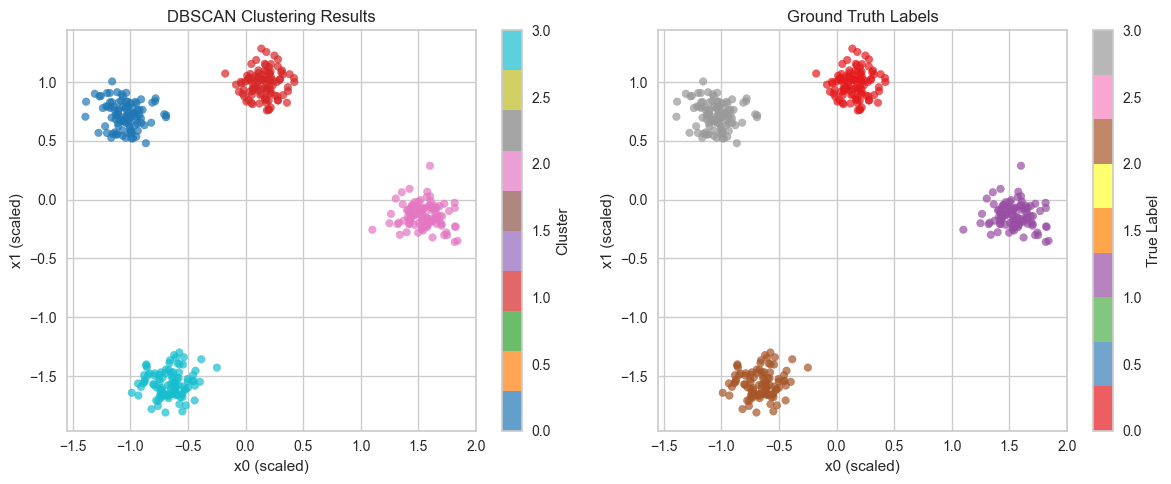

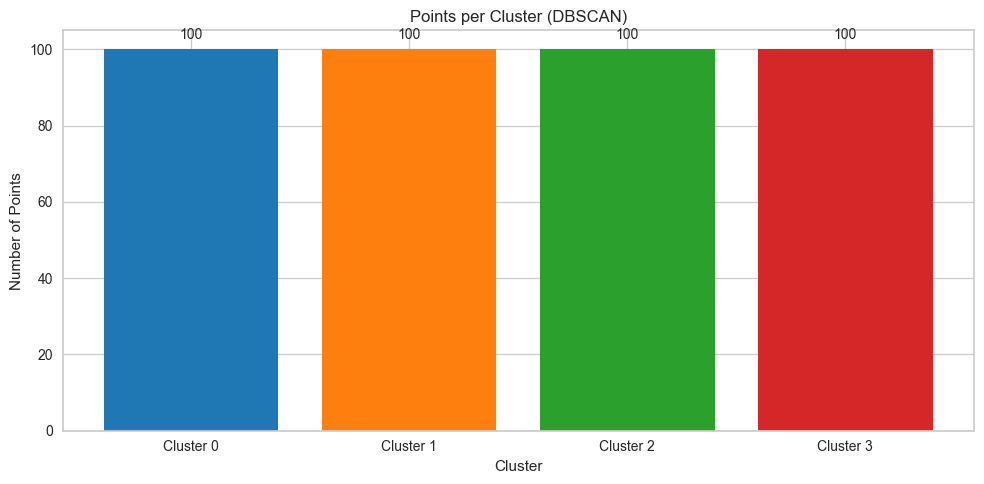


--- Clustering Metrics ---
Number of clusters: 4
Number of noise points: 0 (0.0%)
Silhouette Score (excluding noise): 0.8604
Adjusted Rand Index (vs ground truth): 1.0000


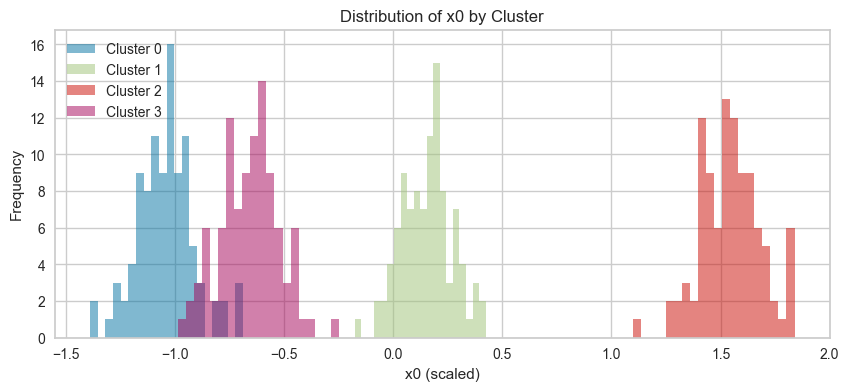


Saved dbscan_pycaret_results.csv


In [7]:
# --- Visualizations ---
if assigned is not None:
    labels = assigned['Cluster'].values
    
    # --- Visualization 1: Scatter plot of clusters ---
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(df_s['x0'], df_s['x1'], c=labels, cmap='tab10', s=30, alpha=0.7)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('x0 (scaled)')
    plt.ylabel('x1 (scaled)')
    plt.title('DBSCAN Clustering Results')
    # Mark noise points
    noise_mask = labels == -1
    if noise_mask.any():
        plt.scatter(df_s.loc[noise_mask, 'x0'], df_s.loc[noise_mask, 'x1'], 
                    c='black', marker='x', s=50, label=f'Noise ({noise_mask.sum()} pts)')
        plt.legend()
    
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(df_s['x0'], df_s['x1'], c=y_true, cmap='Set1', s=30, alpha=0.7)
    plt.colorbar(scatter2, label='True Label')
    plt.xlabel('x0 (scaled)')
    plt.ylabel('x1 (scaled)')
    plt.title('Ground Truth Labels')
    
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Cluster distribution bar chart ---
    unique_labels, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    colors = ['gray' if l == -1 else plt.cm.tab10(l % 10) for l in unique_labels]
    bar_labels = ['Noise' if l == -1 else f'Cluster {l}' for l in unique_labels]
    bars = plt.bar(bar_labels, counts, color=colors)
    plt.xlabel('Cluster')
    plt.ylabel('Number of Points')
    plt.title('Points per Cluster (DBSCAN)')
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(count), 
                 ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

    # --- Visualization 3: Metrics ---
    print('\n--- Clustering Metrics ---')
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f'Number of clusters: {n_clusters}')
    print(f'Number of noise points: {n_noise} ({100*n_noise/len(labels):.1f}%)')
    
    # Silhouette score (excluding noise)
    non_noise_mask = labels != -1
    if non_noise_mask.sum() > 1 and len(np.unique(labels[non_noise_mask])) > 1:
        sil = silhouette_score(df_s[non_noise_mask], labels[non_noise_mask])
        print(f'Silhouette Score (excluding noise): {sil:.4f}')
    
    # ARI with ground truth
    from sklearn.metrics import adjusted_rand_score
    ari = adjusted_rand_score(y_true, labels)
    print(f'Adjusted Rand Index (vs ground truth): {ari:.4f}')

    # --- Visualization 4: Cluster density plot ---
    plt.figure(figsize=(10, 4))
    for cl in np.unique(labels):
        if cl == -1:
            continue
        mask = labels == cl
        plt.hist(df_s.loc[mask, 'x0'], bins=20, alpha=0.5, label=f'Cluster {cl}')
    plt.xlabel('x0 (scaled)')
    plt.ylabel('Frequency')
    plt.title('Distribution of x0 by Cluster')
    plt.legend()
    plt.show()

    # --- Save results ---
    assigned.to_csv('dbscan_pycaret_results.csv', index=False)
    print('\nSaved dbscan_pycaret_results.csv')
else:
    print('No clustering results to visualize')